In [240]:
import re
import time
import math
import requests
import pandas as pd
import numpy as np
import multiprocessing as mp
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
%matplotlib inline

PH_ONE_PAGE = 48
DRUG_ONE_PAGE = 20

In [2]:
class PharmacyScraper:
    def __init__(self):
        self.url = "https://i-teka.kz/almaty/spisokaptek"

    def getLength(self):
        response = requests.get(self.url)
        soup = BeautifulSoup(response.content, "html.parser")
        wrapper = soup.find(class_="top-settings").find("div")
        raw = wrapper.get_text().strip()
        return int(re.findall("[0-9]+", raw)[0])

    def getAll(self):
        pages = math.ceil(self.getLength() / PH_ONE_PAGE)
        result = []
        for page in range(1, pages):
            response = requests.get(self.url + "?page=%d" % page)
            soup = BeautifulSoup(response.content, "html.parser")
            for raw in soup.find_all(class_="phones-btn"):
                item = {}
                item["title"] = raw.attrs["data-title"].strip()
                item["address"] = raw.attrs["data-adress"]
                item["phones"] = raw.attrs["data-phones"]
                result.append(item)
            print("Page %d done" % page)
        return result


ph_scraper = PharmacyScraper()

In [3]:
pharmacies = pd.DataFrame(data=ph_scraper.getAll())

Page 1 done
Page 2 done
Page 3 done
Page 4 done
Page 5 done
Page 6 done
Page 7 done
Page 8 done
Page 9 done
Page 10 done


In [17]:
pharmacies["phones"] = pharmacies["phones"].apply(lambda x: x.replace(" ", ""))
pharmacies = pharmacies[~pharmacies.duplicated()]

def geoGrab(address):
    geolocator = Nominatim(user_agent="medshare-observer")
    location = geolocator.geocode(address)
    time.sleep(0.2)
    return location[1] if location is not None else None

points = pharmacies.address.apply(geoGrab)

# spliting by features
pharmacies["latitude"] = points.apply(lambda x: x[0] if x is not None else None)
pharmacies["longitude"] = points.apply(lambda x: x[1] if x is not None else None)

In [4]:
pharmacies.head()

,key,title,phones,address,latitude,longitude
0,1,2 Квартал,+77272486900,"Алматы, ул. Толе би, д 286/5",43.247517,76.868661
1,2,A - pharma,+77075846366,"Алматы, ул.Жангир хана, 103",43.188764,76.923208
2,3,AGS Фарм (ЭйДжиЭс),+77273152205,"Алматы, ул. Навои, д 7Б",43.217699,76.880362
3,4,AGS Фарм (ЭйДжиЭс),+77272609848,"Алматы, мкрн Керемет, д. 3 кв. 2",NaN,NaN
4,5,Aidim Zhan (Айдим Жан),+77273989018,"Алматы, мкрн. Думан 2, д. 15",NaN,NaN


In [5]:
class DrugsScraper:
    def __init__(self):
        self.baseUrl = "https://i-teka.kz"
        self.url = "https://i-teka.kz/almaty/medicamentsalphabetically"
        # GlossaryTnfull_page=5

    def getLength(self):
        response = requests.get(self.url)
        soup = BeautifulSoup(response.content, "html.parser")
        wrapper = soup.find("h2").find("span").find("strong")
        raw = wrapper.get_text().strip()
        return int(raw)

    def getPage(self, page):
        response = requests.get(
            self.url + "?GlossaryTnfull_page=%d" % page)
        soup = BeautifulSoup(response.content, "html.parser")
        result = []
        for raw in soup.find_all(class_="list-item"):
            item = {}
            title = raw.find(class_="old-h3").find("a")
            item["title"] = title.get_text().strip()
            item["url"] = title.attrs["href"]
            item["status"] = raw.find(class_="info-row").find("div").get_text()
            result.append(item)
        print("Page %d done" % page)
        return result

    def getAll(self):
        pages = math.ceil(self.getLength() / DRUG_ONE_PAGE)
        lists = []
        with mp.Pool(processes=mp.cpu_count()) as pool:
            lists = pool.map(self.getPage, [page for page in range(1, pages)], 5)
        return np.array(lists).flatten().tolist()
drugs_scraper = DrugsScraper()

In [56]:
data = drugs_scraper.getAll()

Page 16 done
Page 1 donePage 6 donePage 11 done


Page 17 done
Page 7 done
Page 12 done
Page 2 done
Page 13 done
Page 3 donePage 8 done

Page 18 done
Page 4 done
Page 9 done
Page 19 done
Page 14 done
Page 10 done
Page 5 done
Page 20 done
Page 15 done
Page 31 donePage 36 done
Page 21 done

Page 26 done
Page 22 donePage 37 done

Page 27 done
Page 32 done
Page 38 donePage 28 done

Page 33 done
Page 23 done
Page 29 done
Page 24 done
Page 34 done
Page 39 done
Page 40 done
Page 30 done
Page 25 done
Page 35 done
Page 51 donePage 56 done

Page 46 done
Page 41 done
Page 47 done
Page 42 done
Page 52 done
Page 57 done
Page 58 done
Page 43 donePage 53 done

Page 48 done
Page 54 donePage 59 done
Page 44 done

Page 49 done
Page 50 donePage 45 done

Page 55 donePage 60 done

Page 76 done
Page 61 done
Page 71 done
Page 66 done
Page 77 donePage 67 done

Page 72 done
Page 62 done
Page 78 done
Page 73 done
Page 68 done
Page 63 done
Page 74 done
Page 79 done
Page 69 done
Page 64 done
Page 80 done
Page 70 

In [6]:
drugs = pd.DataFrame(data=data)

In [7]:
drugs = drugs[~drugs.duplicated()]

drugs["key"] = range(1, len(drugs) + 1)
drugs = drugs[["key", "title", "status", "url"]]
drugs.head()

,key,title,status,url
0,1,30 Дней таблетки № 120,Без рецепта,/almaty/medicaments/30-dney-tabletki-120
1,2,5 дней крем заживляющий с облепиховым маслом 3...,Без рецепта,/almaty/medicaments/5-dney-krem-zazhivlyayusch...
2,3,5 дней крем от пота и запаха 30 гр,Без рецепта,/almaty/medicaments/5-dney-krem-ot-pota-i-zapa...
3,4,5 дней крем от трещин 30 гр,Без рецепта,/almaty/medicaments/5-dney-krem-ot-treschin-30-gr
4,5,5 дней лосьон от пота и запаха 50 мл,Без рецепта,/almaty/medicaments/5-dney-losjon-ot-pota-i-za...


In [193]:
class DrugsToPhScraper:
    def __init__(self):
        self.url = "https://i-teka.kz"

    def getLength(self):
        return len(drugs)

    def getPage(self, page):
        global drugs_analogs, drugs
        try:
            drug_idx = drugs["key"] == page
            drug = drugs[drug_idx].values[0]
            response = requests.get(self.url + drug[3])
            soup = BeautifulSoup(response.content, "html.parser")
            result = []
            for raw in soup.find_all(class_="gtm_block_apteka"):
                item = {}
                ph_title = raw.find(class_="title").get_text().strip()
                pharmacy = pharmacies[pharmacies["title"] == ph_title].values[0]
                item["pharmacy-id"] = pharmacy[0]
                item["drug-id"] = drug[0]
                price_raw = re.findall("[0-9]+", raw.find(class_="price").get_text().replace(" ", ""))
                if len(price_raw) == 0:
                    item["price"] = None
                else:
                    item["price"] = int(price_raw[0])
                result.append(item)
            # instruction_modal = soup.find(class_="instruction-modal")
            # if instruction_modal is not None:
            #     drugs.at[drugs[drug_idx].index[0], "instructions"] = instruction_modal.find(class_="instruction-full").find("span")
            analogs_modal = soup.find(class_="analogs-modal")
            analogs = None
            if analogs_modal is not None:
                container = analogs_modal.find(class_="list")
                analogs_list = []
                for analog in container.find_all(class_="list-item"):
                    title = analog.find(class_="info").find("h2").find("a").get_text().strip()
                    temp = drugs[drugs["title"] == title].values[0]
                    if len(temp) != 0:
                        analogs_list.append(str(temp[0]))
                if len(analogs_list) != 0:
                    analogs = ",".join(analogs_list)
            if page % 1000 == 0:
                print("Page %d done" % page)
            return [result, analogs]
        except:
            return [None, None]

    def getAll(self):
        pages = self.getLength()
        lists = []
        with mp.Pool(processes=mp.cpu_count()) as pool:
            return np.array(pool.map(self.getPage, [page for page in range(1, pages + 1)], 5))
drugs_to_ph_scraper = DrugsToPhScraper()

In [212]:
data = drugs_to_ph_scraper.getAll()

Page 1000 done
Page 2000 done
Page 3000 done
Page 4000 done
Page 5000 done
Page 6000 done
Page 7000 done
Page 8000 done
Page 9000 done
Page 10000 done
Page 11000 done
Page 12000 done
Page 13000 done
Page 14000 done
Page 15000 done
Page 16000 done


In [222]:
temp = np.array(data, copy=True)
drugs["analogs"] = temp.T[1]
temp = [j for i in temp.T[0] if i is not None for j in i]

In [225]:
drugs_to_ph = pd.DataFrame(data=temp)
drugs_to_ph["key"] = range(1, len(drugs_to_ph) + 1)
drugs_to_ph = drugs_to_ph[["key", "pharmacy-id", "drug-id", "price"]]
drugs_to_ph.head()

,key,pharmacy-id,drug-id,price
0,1,461,1,12100.0
1,2,13,1,11789.0
2,3,137,2,NaN
3,4,118,3,625.0
4,5,13,3,650.0


In [238]:
data = []
for drug in drugs[~drugs["analogs"].isnull()].values:
    analogs = drug[4].split(",")
    for analog in analogs:
        item = {}
        item["drug-id"] = drug[0]
        item["analog-id"] = analog
        data.append(item)
drugs_analogs = pd.DataFrame(data=data)
drugs_analogs["key"] = range(1, len(drugs_analogs) + 1)
drugs_analogs = drugs_analogs[["key", "drug-id", "analog-id"]]
drugs_analogs.head()

,key,drug-id,analog-id
0,1,10,9748
1,2,10,9749
2,3,306,2478
3,4,306,4249
4,5,306,10145


In [239]:
drugs.to_csv(r"drugs.csv", index=False)
pharmacies.to_csv(r"pharmacies.csv", index=False)
drugs_to_ph.to_csv(r"drugs_to_ph.csv", index=False)
drugs_analogs.to_csv(r"drugs_analogs.csv", index=False)

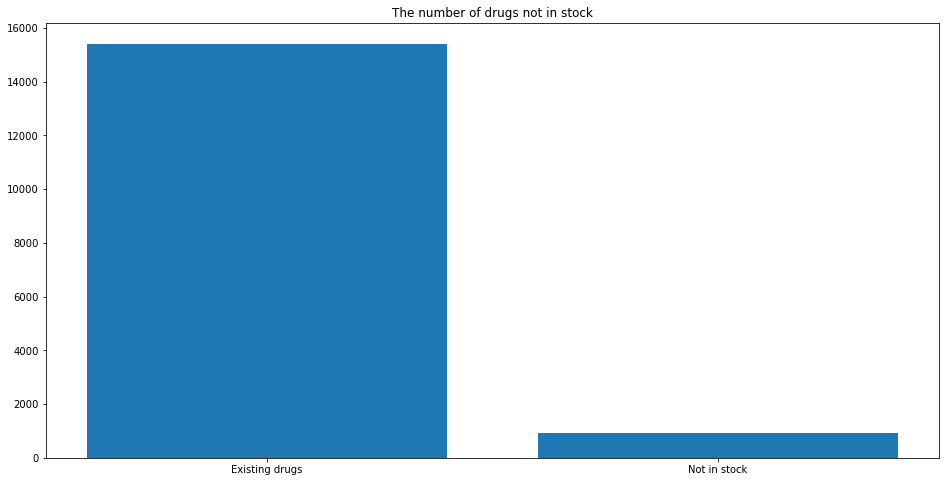

In [259]:
mask = drugs["key"].isin(drugs_to_ph["drug-id"].values)
existing_drugs = len(drugs[mask])
not_existing_drugs = len(drugs[~mask])

plt.figure(figsize=(16, 8))
plt.bar(["Existing drugs", "Not in stock"], [existing_drugs, not_existing_drugs])
plt.title("The number of drugs not in stock")
plt.show()